In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import collections
import shap
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import re
import string
import warnings
from datetime import datetime
import time


#import cv2
import pydicom as dicom
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv('train.csv')
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [3]:
df.tail()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0
33125,ISIC_9999806,IP_0046310,male,45.0,torso,nevus,benign,0


In [4]:
df.shape

(33126, 8)

In [5]:
df.isnull().sum()

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [7]:
df['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

Number and percentage of benign and malignant images
0    32542
1      584
Name: target, dtype: int64
0    98.237034
1     1.762966
Name: target, dtype: float64


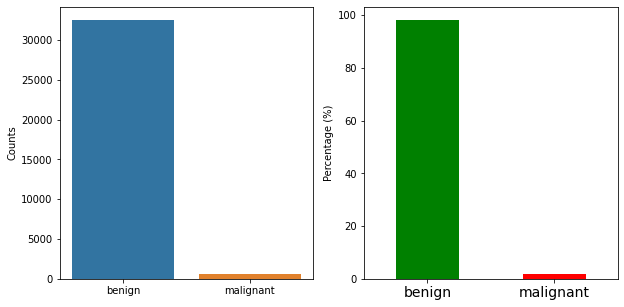

In [8]:
print("Number and percentage of benign and malignant images")
print(df.target.value_counts())
print(df.target.value_counts()*100/df.target.count())

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
x = df.target.replace(to_replace=[0, 1], value=['benign','malignant'])
g1=sns.countplot(x=x,ax=ax[0])
g1.set(ylabel='Counts')
#g1.set(title='Count plot of lesion images')
g1.set(xlabel=None)


y=x.value_counts()*100/len(df.target)
g2=y.replace(to_replace=[0, 1], value=['benign','malignant']).plot(kind='bar', color=('g', 'r'))
plt.ylabel('Percentage (%)')
#plt.title('Percentage of lesion image')
g2.set_xticklabels(g2.get_xticklabels(), rotation=0,size=14)
plt.show()




In [9]:
df.sex.value_counts()

male      17080
female    15981
Name: sex, dtype: int64

target      0    1
sex               
female  15761  220
male    16716  364
 
target          0         1
sex                        
female  98.623365  1.376635
male    97.868852  2.131148


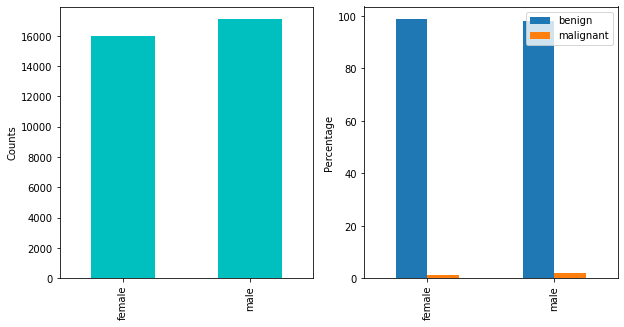

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
freq_df = df.groupby(['sex'])['target'].value_counts().unstack()

print(freq_df)
print(" ")
ax1=freq_df.plot(kind="bar", stacked=True,ax=ax[0],color=['c'],legend=False)

ax1.set_xlabel(None)

ax1.set_ylabel('Counts')
#ax1.set_title('image count in sex')



pct_df = freq_df.divide(freq_df.sum(axis=1)/100, axis=0)
print(pct_df)
ax2=pct_df.plot(kind="bar", stacked=False,ax=ax[1])
ax2.set_xlabel(None)
ax2.set_ylabel('Percentage')
#ax2.set_title('image percentage in sex')
ax2.legend(['benign', 'malignant'])
plt.show()

In [11]:
df.anatom_site_general_challenge.value_counts()

torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
palms/soles          375
oral/genital         124
Name: anatom_site_general_challenge, dtype: int64

Text(0.5, 1.0, 'Malignant count vs anatomic location')

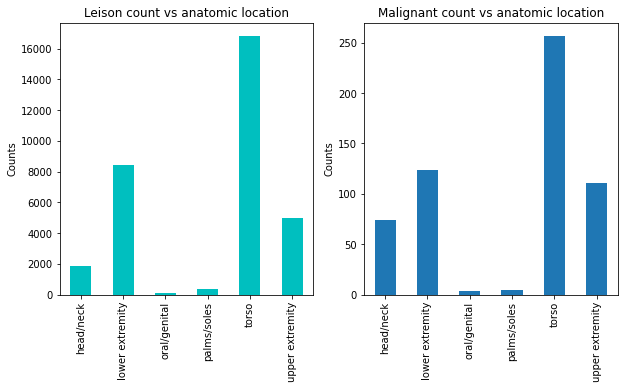

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
freq_df = df.groupby(['anatom_site_general_challenge'])['target'].value_counts().unstack()

ax1=freq_df.plot(kind="bar", stacked=True,ax=ax[0],color=['c'],legend=False)


ax1.set_xlabel(None)

ax1.set_ylabel('Counts')
ax1.set_title('Leison count vs anatomic location')

#pct_df = freq_df.divide(freq_df.sum(axis=1)/100, axis=0)
ax2=freq_df[1].plot(kind="bar", stacked=False,ax=ax[1],legend=None)
ax2.set_xlabel(None)
ax2.set_ylabel('Counts')
ax2.set_title('Malignant count vs anatomic location')
#ax2.legend(None)


In [13]:
print("Unique patients:-",df.patient_id.nunique())


Unique patients:- 2056


In [14]:
#print(df.patient_id.value_counts().head())
#print(df.patient_id.value_counts().tail())

In [15]:
Patient_id=[]
Patient_image_count=[]
Patient_melanoma_image_count=[]
Patient_melanoma_label=[]

#Id_image_count=[]
Id_melanoma_count=[]
Non_melanoma=0
Melanoma=0


Melanoma_patient_image_count=[]
A=0
B=0
#print("Patient_id","Lesion images", "Menalonma images")
for i in df.patient_id.unique():
    count=df.target[df.patient_id==i].count()
    
    Patient_id.append(i)
    Patient_image_count.append(count)
    
    #Id_image_count.append(count)
    

    counter=0
    
    df_ind=df[df.patient_id==i]
    for s in range(count):
        if (df_ind.target.iloc[s]==1):
            counter+=1
        
            
    if (counter>0):
        A+=count
        B+=counter
        Id_melanoma_count.append(counter)
        Patient_melanoma_image_count.append(counter)
        Patient_melanoma_label.append(1)
        Melanoma+=1
        
        #print(i,count,counter)
    else:
        Patient_melanoma_image_count.append(0)
        Patient_melanoma_label.append(0)
        
        Non_melanoma+=1
        

     

In [16]:
print("No of patients with melanoma and non-melanoma:-",Melanoma,Non_melanoma)
print("Total images of patient having melanoma:-",A)
print("Total melanoma images:-",B)        
print("Percentage of patients having melanoma:", Melanoma*100/(Non_melanoma+Melanoma) )


No of patients with melanoma and non-melanoma:- 428 1628
Total images of patient having melanoma:- 6927
Total melanoma images:- 584
Percentage of patients having melanoma: 20.817120622568094


In [17]:
dict = {'Patient_id': Patient_id, 'Total_image': Patient_image_count, 'Melanoma_image': Patient_melanoma_image_count,"Melanoma_label":Patient_melanoma_label} 
    
df_count = pd.DataFrame(dict)

In [18]:
df_count.head()

,Patient_id,Total_image,Melanoma_image,Melanoma_label
0,IP_7279968,115,0,0
1,IP_3075186,24,0,0
2,IP_2842074,5,0,0
3,IP_6890425,22,1,1
4,IP_8723313,20,0,0


In [19]:
df_count.sort_values(by='Melanoma_image',ascending=False)

,Patient_id,Total_image,Melanoma_image,Melanoma_label
151,IP_7373371,42,8,1
1702,IP_9111321,13,6,1
607,IP_3237442,8,5,1
973,IP_2412574,23,5,1
612,IP_7785592,66,4,1
...,...,...,...,...
762,IP_7250026,34,0,0
761,IP_9756233,15,0,0
760,IP_6616887,10,0,0
759,IP_1307115,30,0,0


In [20]:
df_count.to_csv("Melanoma_patient_info.csv",index=False)

In [21]:
df.diagnosis.value_counts()

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
atypical melanocytic proliferation        1
cafe-au-lait macule                       1
Name: diagnosis, dtype: int64

Text(0.5, 1.0, 'Box plot showing variation in the melanoma images of patient')

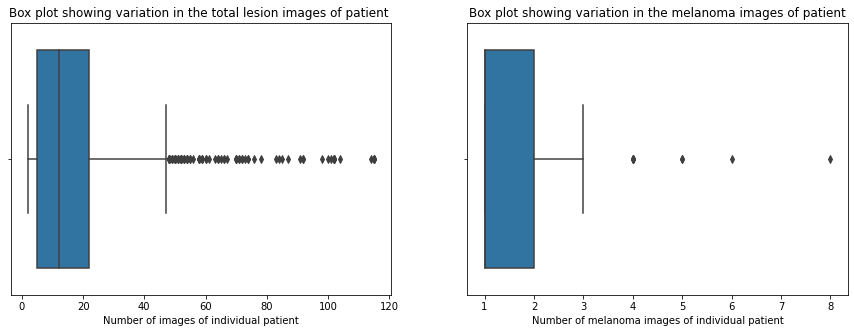

In [22]:
import seaborn as sns
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
#ax = sns.boxplot(x=Patient_image_count)
ax = sns.boxplot(x=df_count.Total_image)
plt.xlabel('Number of images of individual patient')
plt.title('Box plot showing variation in the total lesion images of patient ')

plt.subplot(1,2,2)
x = Id_melanoma_count
#sns.boxplot(x =Id_melanoma_count)
sns.boxplot(x =df_count[df_count.Melanoma_image!=0].Melanoma_image)
#plt.ylabel('Counts')
plt.xlabel('Number of melanoma images of individual patient')
plt.title('Box plot showing variation in the melanoma images of patient')


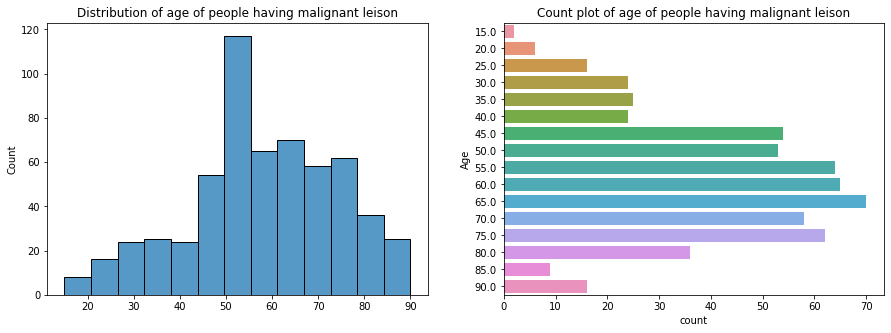

In [23]:
age = []
for i in range(df.shape[0]):
    try: 
        if df['target'].iloc[i] == 1:
            age.append(df['age_approx'].iloc[i]) 
    except:
        pass
    
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(age)
plt.title('Distribution of age of people having malignant leison')
plt.subplot(1,2,2)
sns.countplot(y = age)
plt.ylabel('Age')
plt.title('Count plot of age of people having malignant leison')
plt.show()

In [24]:
from pydicom import dcmread
from skimage import data, color

def dicom_to_array(filename):
    d = dicom.read_file(filename)
    a = d.pixel_array
    return a,d

In [25]:
#select balanced data set to visualize both images
import random
seed=5
s0 = df.target[df.target.eq(0)].sample(50,random_state=seed).index
s1 = df.target[df.target.eq(1)].sample(50,random_state=seed).index
#print(s0)
#print(s1)
dff= df.loc[s0.union(s1)]
dff['target'].value_counts()

1    50
0    50
Name: target, dtype: int64

In [26]:
dff.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
158,ISIC_0167093,IP_8029095,female,45.0,upper extremity,unknown,benign,0
1817,ISIC_0647224,IP_5064161,male,30.0,lower extremity,melanoma,malignant,1
2693,ISIC_0906053,IP_2577172,female,65.0,lower extremity,unknown,benign,0
2856,ISIC_0953317,IP_2278509,male,65.0,torso,melanoma,malignant,1
3119,ISIC_1037315,IP_0623861,male,60.0,lower extremity,melanoma,malignant,1


In [27]:
import os
os.chdir("/Volumes/RAJ_256/Melanoma1")

<class 'pydicom.dataset.FileDataset'>
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 220
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.5962.99.1.7658.1003.1589903823523.1.1.0.0.0
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.5962.99.2
(0002, 0013) Implementation Version Name         SH: 'PIXELMEDJAVA001'
(0002, 0016) Source Application Entity Title     AE: 'OURAETITLE'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0014) Instance Creator UID                UI: 1.3.6.1.4.1.5962.99.3
(0008, 0016) SOP Class UID                       UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0008, 0018) SO

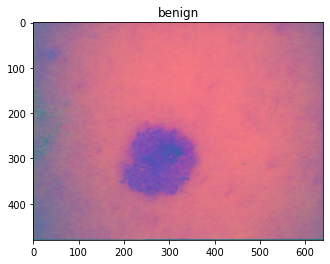

image size:- (480, 640, 3)
smallest intensity:- 0
largest intensity:- 250
   
<class 'pydicom.dataset.FileDataset'>
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 220
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.5962.99.1.7658.1003.1589903823523.1.1.0.0.0
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.5962.99.2
(0002, 0013) Implementation Version Name         SH: 'PIXELMEDJAVA001'
(0002, 0016) Source Application Entity Title     AE: 'OURAETITLE'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0014) Instance Creator UID                UI: 1.3.6.1.4.1.5962.99.3
(0008, 0016) SOP Class 

In [28]:
from pydicom import dcmread
from skimage import data, color

index=0

image ='train/'+dff['image_name'].iloc[index] +'.dcm'
ds = dicom.dcmread(image)
ds = dcmread(image)
print(type(ds))
print(ds)
#plt.imshow(ds.pixel_array)



def dicom_to_array(filename):
    d = dicom.read_file(filename)
    a = d.pixel_array
    return a,d
    #return np.array(a),d


a1,d = dicom_to_array(image)
plt.title(df['benign_malignant'].iloc[index])
plt.imshow(a1)
plt.show()
print("image size:-",a1.shape)
print("smallest intensity:-", np.ndarray.min(a1) )
print("largest intensity:-", np.ndarray.max(a1) )
print("   ")
print(type(d))
print(d)


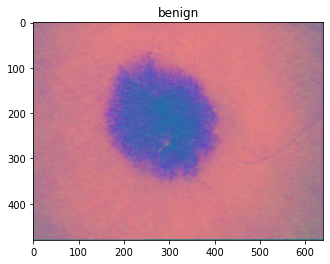

(0018, 0015) Body Part Examined                  CS: 'LOWER EXTREMITY'
image size:- (480, 640, 3)
smallest intensity:- 2
largest intensity:- 242


In [29]:
index=1

image ='train/'+dff['image_name'].iloc[index] +'.dcm'

a1,d = dicom_to_array(image)
plt.title("Malignant")
#plt.axis('off')
plt.imshow(a1)
plt.title(df['benign_malignant'].iloc[index])
plt.show()


print(d['BodyPartExamined'])
print("image size:-",a1.shape)
print("smallest intensity:-", np.ndarray.min(a1) )
print("largest intensity:-", np.ndarray.max(a1) )

#print(type(d))
#print(d)
#print(d.file_meta)


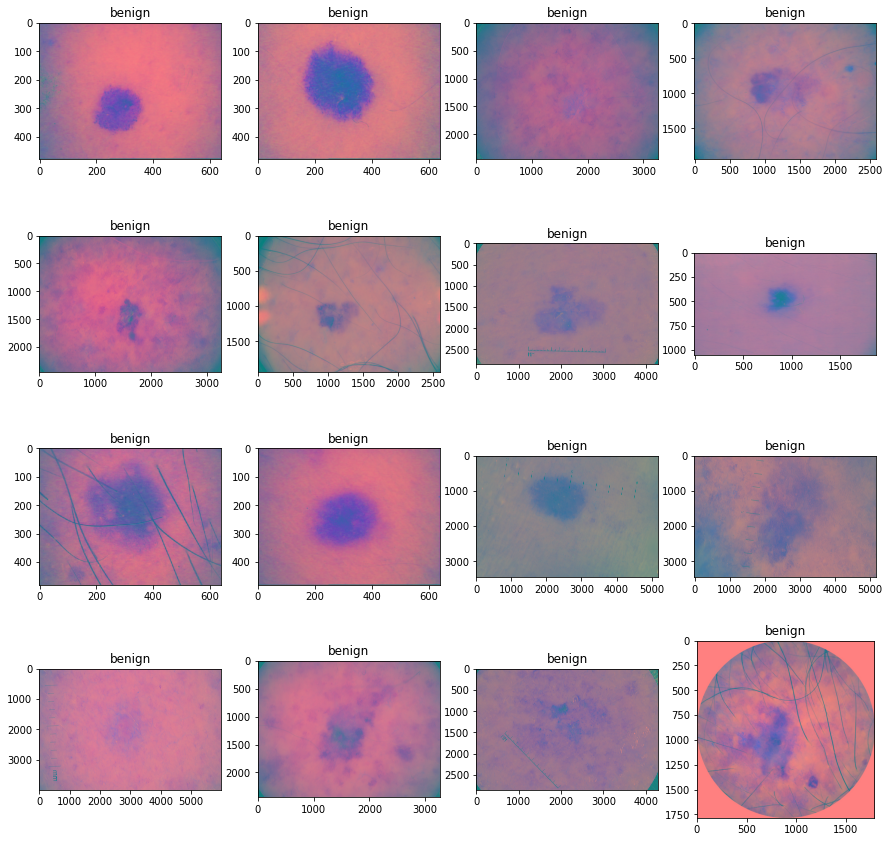

In [30]:
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 4

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    img = image ='train/'+dff['image_name'].iloc[i] +'.dcm'
    a1,d = dicom_to_array(image)
      # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    # Hide grid lines
    ax[-1].grid(False)

    # Hide axes ticks
    #ax[-1].set_xticks([])
    #ax[-1].set_yticks([])
    ax[-1].set_title(df['benign_malignant'].iloc[i])

    plt.imshow(a1)



In [31]:
df_count[df_count.Melanoma_image!=0][['Patient_id','Total_image',"Melanoma_image"]]

,Patient_id,Total_image,Melanoma_image
3,IP_6890425,22,1
10,IP_9802602,14,1
29,IP_1264754,36,3
41,IP_3076695,11,1
42,IP_3397861,34,1
...,...,...,...
2038,IP_9942136,3,1
2040,IP_0585473,3,2
2042,IP_2320445,3,1
2052,IP_1545708,3,1


In [32]:
df_select=df[df.patient_id=='IP_6349217'].image_name
df_select



26454    ISIC_8023454
31664    ISIC_9571842
32641    ISIC_9854454
Name: image_name, dtype: object

In [33]:
df_select.iloc[1]

'ISIC_9571842'

Multiple images of same patient


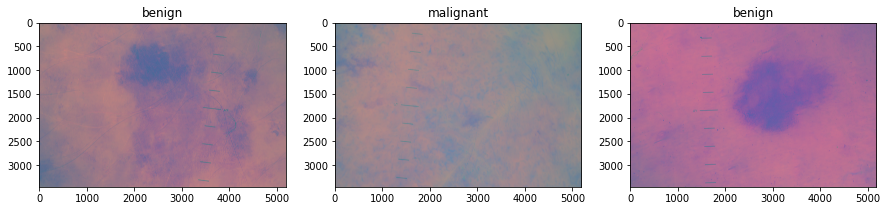

In [34]:
print("Multiple images of same patient")

fig = plt.figure(figsize=(15, 15))
columns = 3
rows = 1

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    img = image ='train/'+df_select.iloc[i] +'.dcm'
    a1,d = dicom_to_array(image)
      # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    # Hide grid lines
    ax[-1].grid(False)

    # Hide axes ticks
    #ax[-1].set_xticks([])
    #ax[-1].set_yticks([])
    #ax[-1].set_title(df['benign_malignant'].iloc[i])
    ax[-1].set_title(df[df.image_name==df_select.iloc[i]].benign_malignant.iloc[0])

    plt.imshow(a1)




In [35]:
df_count[df_count.Melanoma_image!=0].sort_values(by='Total_image')

,Patient_id,Total_image,Melanoma_image,Melanoma_label
2054,IP_6349217,3,1,1
1795,IP_2548997,3,1,1
1798,IP_0957064,3,2,1
1800,IP_8124898,3,1,1
1313,IP_0623861,3,1,1
...,...,...,...,...
564,IP_0093378,83,1,1
128,IP_6512345,85,1,1
162,IP_7330399,101,1,1
57,IP_1139701,102,1,1
